In [32]:
# looking for fitfiles in my default folder
import glob

files = glob.glob(r"test_input\*.fit")

In [33]:
# parsing  the last recorded fitfile
import fitparse

fitfile = fitparse.FitFile(files[0])

In [34]:
# creating an empty dataframe
import pandas as pd

data = {"timestamp":[],
        "position_lat":[],
        "position_long":[],
        "altitude":[],
        "enhanced_altitude":[],
        "speed":[],
        "enhanced_speed": [],
        "temperature": [],
        "distance": [],
        "gps_accuracy":[]}
df = pd.DataFrame(data)

In [35]:
# reading the recorded data into my dataframe

messages = fitfile.messages
for m in messages:
    if m.mesg_num == 20: # a recorded datamessage
        
        # translate semicircles to degrees
        pos_lat = m.get_value("position_lat") * 180 / 2**31 
        pos_long = m.get_value("position_long") * 180 / 2**31

        data_tmp = {
            "timestamp":m.get_value("timestamp"),
            "position_lat":pos_lat,
            "position_long":pos_long,
            "altitude":m.get_value("altitude"),
            "enhanced_altitude":m.get_value("enhanced_altitude"),
            "speed":m.get_value("speed"),
            "enhanced_speed":m.get_value("enhanced_speed"),
            "temperature":m.get_value("temperature"),
            "distance":m.get_value("distance"),
            "gps_accuracy":m.get_value("gps_accuracy")
        }
        df = df.append(data_tmp, ignore_index=True)

In [36]:
# read the date from the recorded timestamp as title of the following plot
import time

date = df.timestamp.head(1)[0].date()

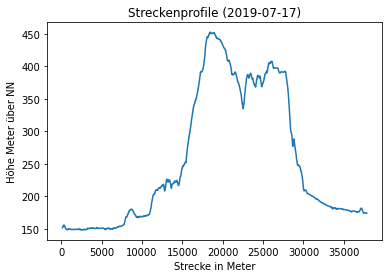

In [37]:
# plotting the profil of my tour
from matplotlib import pyplot as plt

plt.plot(df.distance, df.altitude)
plt.title("Streckenprofile ({})".format(date))
plt.xlabel("Strecke in Meter")
plt.ylabel("Höhe Meter über NN")
#plt.xticks([10000, 20000, 30000], [10, 20, 30])
plt.show()

In [38]:
# create a linestring out of all records
from shapely.geometry import LineString, Point

coordinates = []
for index, row in df.iterrows():
    coordinates.append((row.position_lat, row.position_long))
route = LineString(coordinates)

# looking for the center of my route for adjusting the following map
location = list(route.centroid.coords)[0]

In [39]:
# showing the track on a map
import folium

map = folium.Map(location=location)
folium.PolyLine(coordinates, color="blue", weight=5, opacity=1).add_to(map)
map

In [41]:
# saving the track as a shapefile
import geopandas as gpd

def swap(x):
    # it is necessarx to swap the coordinates
    coords = list(x.coords)
    coords = [Point(t[1], t[0]) for t in coords]
    return LineString(coords)

dict = {"raw_data":["fitfile_name"], "geometry":[swap(route)]}
df = gpd.GeoDataFrame(dict, crs="epsg:4326")
df.to_file("test1.shp")